<a href="https://colab.research.google.com/github/tjwikki12/Ideathon/blob/main/Ideathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
# spacy.require_gpu()
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df=pd.read_csv("/content/reviews.csv")

In [5]:
df.columns

Index(['User', 'Location', 'Review Date', 'Rating', 'Review Highlight',
       'Review', 'Date of Experience'],
      dtype='object')

In [6]:
df.rename(columns={'Review Highlight': 'content'}, inplace=True)

In [7]:
import pandas as pd
from tqdm.auto import tqdm
import spacy
import re

# Load a pre-trained SpaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Example Telecom Glossary
telecom_glossary = set([
    '5g', 'wifi', 'router', 'fiber', 'mobile', 'signal', 'network', 'internet', 'lte', 'sms', 'carrier', 'bandwidth', 'data', 'tower'
])

# Function to clean the text
def clean_text(text):
    # Process the text with spaCy to detect named entities
    doc = nlp(text)

    # Remove personal names (NER entities of type "PERSON")
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            text = text.replace(ent.text, ' ')

    # Convert to lowercase
    text = text.lower()

    # Remove text inside square brackets (e.g., [product] or [info])
    text = re.sub(r'\[.*?\]', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove words containing numbers (e.g., phone123)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)

    # Preserve telecom glossary words by checking against the glossary set
    words = text.split()
    cleaned_words = [word if word in telecom_glossary else word for word in words]
    text = ' '.join(cleaned_words)

    return text

In [8]:
# Clean text columns
df['content_clean'] = df['content'].progress_apply(lambda x: clean_text(x))

100%|██████████| 4480/4480 [00:37<00:00, 120.25it/s]


In [9]:
import spacy
from tqdm import tqdm

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")

# Access stopwords directly via `nlp.Defaults.stop_words`
stopwords = nlp.Defaults.stop_words

# Define the lemmatization function
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):  # Efficient processing with nlp.pipe
        # Lemmatize, remove stopwords, and join tokens back into a string
        sent = [token.lemma_ for token in doc if not token.is_stop]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [10]:
df['content_lemmatized'] = lemmatization(df['content_clean'])

4480it [00:04, 1048.59it/s]


In [11]:
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        # Extracting all nouns (singular, plural, proper nouns)
        sent = [token.text for token in doc if token.pos_ == 'NOUN']
        pos_sentences.append(' '.join(sent))  # Join the nouns into a single string
    return pos_sentences

In [12]:
df["content_POS_removed"] = extract_pos_tags(df['content_clean'])

4480it [00:03, 1189.82it/s]


In [13]:
# Write your code here to visualise the data according to the 'Complaint' character length
df['content_length'] = df['content_clean'].str.len()
df['content_lemmatized_length'] = df['content_lemmatized'].str.len()
df['content_POS_removed_length'] = df['content_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df['content_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df['content_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df['content_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='content Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

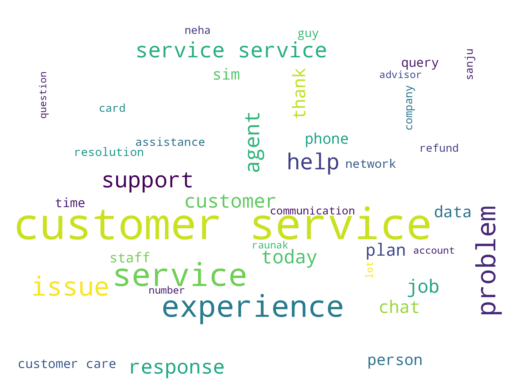

In [14]:
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df['content_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [15]:
#Removing -PRON- from the text corpus
df['content_clean'] = df['content_POS_removed'].str.replace('-PRON-', '')

In [16]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [17]:
#Print the top 10 words in the unigram frequency and plot the same using a bar graph
unigram = get_top_n_words(df['content_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

service 868
customer 608
experience 203
problem 139
issue 124
help 100
support 98
agent 83
response 77
today 71


In [18]:
#Print the top 10 words in the bigram frequency and plot the same using a bar graph
bigram = get_top_n_words(df['content_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

customer service 445
customer care 31
customer services 23
customer support 20
service experience 13
service today 10
customer experience 8
service customer 8
class service 8
service agent 7


In [19]:
#Print the top 10 words in the trigram frequency and plot the same using a bar graph
trigram = get_top_n_words(df['content_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')

customer service experience 9
customer care service 6
customer service team 6
customer service agent 6
customer service today 5
customer service representative 5
notch customer service 4
experience customer service 3
customer service raunak 3
deals customer service 2


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Define the categories with representative keywords or descriptions
categories = {
    'Network': ['network', 'signal', 'tower', 'connection', 'bandwidth', 'wifi'],
    'Mobile': ['mobile', '5g', 'data', 'cell', 'LTE', 'smartphone'],
    'Customer Service': ['support', 'service', 'help', 'assist', 'response', 'call center','customer experience','service experience','customer service','customer support','service agent'],
    'Billing': ['billing', 'payment', 'invoice', 'charge', 'subscription'],
    'Internet': ['internet', 'router', 'fiber', 'bandwidth', 'connection']

}

# Step 2: Prepare the category descriptions
category_descriptions = {}
for category, keywords in categories.items():
    category_descriptions[category] = ' '.join(keywords)

# Step 3: Vectorize the content_clean column and category descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the TF-IDF vectorizer on the category descriptions and content_clean together
category_vectors = vectorizer.fit_transform(list(category_descriptions.values()))
content_vectors = vectorizer.transform(df['content_clean'])

# Step 4: Calculate the cosine similarity between each content entry and all categories
def get_category(content_vector):
    similarities = cosine_similarity(content_vector, category_vectors)
    # Get the category with the highest similarity score
    category_index = np.argmax(similarities)
    return list(category_descriptions.keys())[category_index]

# Step 5: Apply the function to categorize the content
df['category'] = [get_category(content_vector) for content_vector in content_vectors]




In [21]:
import plotly.express as px

# Step 1: Count the number of reviews in each category
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Step 2: Create a bar chart to visualize the distribution of reviews by category
fig = px.bar(category_counts, x='Category', y='Count',
             title='Distribution of Reviews by Category',
             labels={'Category': 'Category', 'Count': 'Number of Reviews'},
             color='Category',
             color_continuous_scale='Viridis')

# Show the bar chart
fig.show()


In [22]:
df['category'].value_counts()

,count
category,
Network,2915
Customer Service,1476
Mobile,58
Billing,18
Internet,13


In [23]:
def classify_review_content(review):
    # Check if the review is a valid string before processing
    if isinstance(review, str):
        # Convert the review to lowercase to make the search case-insensitive
        review = review.lower()

        # Check for keywords and assign categories
        if 'network' in review or 'signal' in review or 'coverage' in review:
            return 'Network'
        elif 'customer service' in review or 'help' in review or 'support' in review:
            return 'Customer Service'
        elif 'mobile' in review or 'phone' in review or 'cell' in review or 'smartphone' in review:
            return 'Mobile'
        elif 'billing' in review or 'payment' in review or 'charges' in review or 'invoice' in review:
            return 'Billing'
        elif 'internet' in review or 'wifi' in review or 'connection' in review or 'online' in review:
            return 'Internet'
        else:
            return 'Other'  # Default category if none of the keywords are found
    else:
        return 'Other'  # If it's not a string, categorize it as 'Other'

def match_category(review, category):
    # Check if the review is a valid string before processing
    if isinstance(review, str):
        # Convert the review to lowercase to make the search case-insensitive
        review = review.lower()

        # Check if the review contains keywords related to the assigned category
        if category == 'Network':
            if 'network' in review or 'signal' in review or 'coverage' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Customer Service':
            if 'customer service' in review or 'help' in review or 'support' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Mobile':
            if 'mobile' in review or 'phone' in review or 'cell' in review or 'smartphone' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Billing':
            if 'billing' in review or 'payment' in review or 'charges' in review or 'invoice' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Internet':
            if 'internet' in review or 'wifi' in review or 'connection' in review or 'online' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        else:
            return 'Mismatch'
    else:
        return 'Mismatch'  # If it's not a string, categorize as mismatch




In [24]:
# Apply the functions to classify and match categories for each review
df['review_category'] = df['Review'].apply(classify_review_content)
df['category_match'] = df.apply(lambda row: match_category(row['Review'], row['review_category']), axis=1)

In [25]:
def combine_columns(row):
    if row['category'] == row['review_category']:
        return row['category']  # If values are similar, keep the value from either column
    else:
        return row['category']

# Apply the function to create a new column
df['matched_category'] = df.apply(combine_columns, axis=1)

In [26]:
df = df.drop(columns=['category_match'])

In [27]:
pip install vaderSentiment

In [28]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the sentiment map to convert text labels to numeric values
sentiment_map = {
    'Positive': 2,  # Assigning 'Positive' to 2
    'Neutral': 1,   # Assigning 'Neutral' to 1
    'Negative': 0   # Assigning 'Negative' to 0
}

# Function to classify sentiment with handling for NaN or empty reviews
def get_sentiment(review):
    if pd.isna(review) or review == "":  # Check for NaN or empty strings
        return 'Neutral'  # Default to Neutral if review is empty or NaN

    sentiment_score = analyzer.polarity_scores(review)
    compound_score = sentiment_score['compound']

    # Classify based on the compound score
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the 'Review' column
df['sentiment'] = df['Review'].apply(get_sentiment)

# Convert the sentiment values to numeric using the sentiment_map
df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)




In [29]:
df['sentiment'].value_counts()

,count
sentiment,
Positive,3693
Neutral,487
Negative,300


In [30]:
# Visualize the sentiment distribution
import plotly.express as px

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot the sentiment distribution
fig = px.bar(sentiment_counts, x='Sentiment', y='Count',
             title='Sentiment Distribution of Reviews',
             labels={'Sentiment': 'Sentiment', 'Count': 'Number of Reviews'},
             color='Sentiment',
             color_continuous_scale='Viridis')

fig.show()


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorize the cleaned text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['content_clean'])

# Convert sparse matrix to DataFrame for easy manipulation
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())


In [33]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())  # Convert sparse matrix to DataFrame
X = X_tfidf_df
y = df[['matched_category','sentiment']]
X.columns = X.columns.astype(str)

In [34]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [35]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with class_weight='balanced' and 100 estimators
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict using the test set
y_pred = model.predict(X_test)


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the RandomForest model
model = RandomForestClassifier(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']  # Replace 'auto' with 'sqrt' or 'log2'
}

# Perform RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=3,  # Use 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Print the best parameters found by random search
print(f"Best parameters: {random_search.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 156}


In [43]:
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the base RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Wrap the RandomForestClassifier inside MultiOutputClassifier
model = MultiOutputClassifier(rf, n_jobs=-1)

# Set up cross-validation with KFold
kf = KFold(n_splits=5)

# Iterate through each fold in KFold
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the multi-output classifier
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print classification report for each output
    for i, col in enumerate(y.columns):  # Loop through each output column
        print(f"Classification report for output {col}:")
        print(classification_report(y_test.iloc[:, i], y_pred[:, i]))


Classification report for output matched_category:
                  precision    recall  f1-score   support

         Billing       1.00      1.00      1.00         3
Customer Service       1.00      1.00      1.00       306
        Internet       1.00      1.00      1.00         3
          Mobile       1.00      1.00      1.00        15
         Network       1.00      1.00      1.00       569

        accuracy                           1.00       896
       macro avg       1.00      1.00      1.00       896
    weighted avg       1.00      1.00      1.00       896

Classification report for output sentiment:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        72
     Neutral       0.00      0.00      0.00        42
    Positive       0.87      0.97      0.92       782

    accuracy                           0.85       896
   macro avg       0.29      0.32      0.31       896
weighted avg       0.76      0.85      0.80       896


In [45]:
# Save the trained model and vectorizer using joblib
import joblib
joblib.dump(model, 'review_classifier_model_rf.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [46]:
# Load the trained model and TF-IDF vectorizer
model = joblib.load('review_classifier_model_rf.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [47]:
# Sample 5 random rows from the 'content' column
test_data = df['content'].sample(n=5)

# Display the test data
print(test_data)


557                  Amazing support
1242      Speedy and helpful service
2285    Problem was solved properly.
402                      Amaan Attar
4411        Very patient and helpful
Name: content, dtype: object


In [48]:
# Transform the test data using the same TF-IDF vectorizer
test_data_tfidf = vectorizer.transform(test_data)

# Check the shape of the transformed data
print(f"Test data shape after TF-IDF: {test_data_tfidf.shape}")


Test data shape after TF-IDF: (5, 662)


In [49]:
predictions = model.predict(test_data_tfidf)  # Use xgb.predict(test_data_tfidf) if using XGBoost

# Display the predictions
print(f"Predictions: {predictions}")

Predictions: [['Customer Service' 'Positive']
 ['Customer Service' 'Positive']
 ['Network' 'Positive']
 ['Network' 'Positive']
 ['Network' 'Positive']]


In [54]:
'''from google.colab import files
df.to_csv('processed_file.csv', index=False)
files.download('processed_file.csv')'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>